Step 1. Generate all possible schedules of all tasks

Initializing Data

In [1]:
import gurobipy as gp
from gurobipy import GRB
from gurobipy import multidict
from gurobipy import quicksum
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
model = gp.Model("FilmProductionScheduler")

# Example data
crews = ["makeup_artist", "lighting", "camera", "sound"]
tasks = ["makeup_scene1", "lighting_scene1", "filming_scene1", "sound_scene1", "makeup_scene2", "lighting_scene2", "filming_scene2", "sound_scene2", "makeup_scene3", "lighting_scene3", "filming_scene3", "sound_scene3"]
scenes = ["scene1", "scene2", "scene3"]
time_slots = range(48)  # 48 half-hour slots in a day 
# Task durations in time slots
task_duration = {"makeup_scene1": 4, "lighting_scene1": 6, "filming_scene1": 12, "sound_scene1": 4, "makeup_scene2": 4, "lighting_scene2": 6, "filming_scene2": 12, "sound_scene2": 4, "makeup_scene3": 4, "lighting_scene3": 6, "filming_scene3": 12, "sound_scene3": 4}
# Crew costs per time slot
crew_cost = {"makeup_artist": 100, "lighting": 150, "camera": 200, "sound": 100}
# crew_availability = {
#     "makeup_artist": [(0, 48)],  # Available 0-24 hours
#     "lighting": [(16, 40)],
#     "camera": [(12, 44)],
#     "sound": [(24, 48)]
# }
crew_availability = {
    "makeup_artist": [(0, 200)],  # Available 0-24 hours
    "lighting": [(16, 200)],
    "camera": [(12, 200)],
    "sound": [(24, 200)]
}
# Task requirements
task_eligibility = {
    "makeup_artist": ["makeup_scene1", "makeup_scene2", "makeup_scene3"],
    "lighting": ["lighting_scene1", "lighting_scene2", "lighting_scene3"],
    "camera": ["filming_scene1", "filming_scene2", "filming_scene3"],
    "sound": ["sound_scene1", "sound_scene2", "sound_scene3"]
}


Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-10


In [3]:
# # Map tasks to scenes
# task_to_scene = {
#     "makeup_scene1": "scene1",
#     "lighting_scene1": "scene1",
#     "filming_scene1": "scene1",
#     "sound_scene1": "scene1",
#     "makeup_scene2": "scene2",
#     "lighting_scene2": "scene2",
#     "filming_scene2": "scene2",
#     "sound_scene2": "scene2",
#     "makeup_scene3": "scene3",
#     "lighting_scene3": "scene3",
#     "filming_scene3": "scene3",
#     "sound_scene3": "scene3"
# }

# # Map crew, tasks to costs
# combinations, cost, time = multidict({
#     ("makeup_artist", "makeup_scene1"): 100,
#     ("makeup_artist", "makeup_scene2"): 100,
#     ("makeup_artist", "makeup_scene3"): 100,
#     ("lighting", "lighting_scene1"): 150,
#     ("lighting", "lighting_scene2"): 150,
#     ("lighting", "lighting_scene3"): 150,
#     ("camera", "filming_scene1"): 200,
#     ("camera", "filming_scene2"): 200,
#     ("camera", "filming_scene3"): 200,
#     ("sound", "sound_scene1"): 100,
#     ("sound", "sound_scene2"): 100,
#     ("sound", "sound_scene3"): 100,
# })

# #
# Budget = 2000



In [4]:
# Create decision variables
x = {}  # x[task, crew, start_time] = 1 if task is assigned to crew starting at time
for task in tasks:
    for crew in crews:
        for t in time_slots:
            if t + task_duration[task] <= len(time_slots):  # Task fits within time horizon
                for start, end in crew_availability[crew]:
                    if start <= t < end and t + task_duration[task] <= end:  # Task fits within crew availability
                        x[task, crew, t] = model.addVar(vtype=GRB.BINARY, name=f"x_{task}_{crew}_{t}")

assignment = {}


In [5]:
# Constraints

# Each task is assigned to exactly one crew and one time slot
for task in tasks:
    model.addConstr(
        quicksum(x[task, crew, t] for crew in crews for t in time_slots
                 if (task, crew, t) in x) >= 1, name=f"assign_{task}"
    )

# Each crew is assigned to at most one task at a time
for crew in crews:
    for t in time_slots:
        model.addConstr(
            quicksum(x[task, crew, t] for task in tasks 
                     if (task, crew, t) in x) <= 1, name=f"crew_{crew}_time_{t}_one_task"
        )

# Each crew is assigned to its job only
for crew in crews:
    for task in tasks:
        if task not in task_eligibility[crew]:
            model.addConstr(
                quicksum(x[task, crew, t] for t in time_slots
                         if (task, crew, t) in x) == 0, name=f"crew_{crew}_task_{task}_not_eligible"
            )

# Crew cannot be assigned overlapping tasks
for crew in crews:
    for t in time_slots:
        active_at_t = []    # List of tasks that are active at time t
        for task in tasks:
            earliest_start = max(0, t - task_duration[task] + 1)
            laterest_start = t
            # Add all possible (task, start_time) pairs that are active at time t
            for start_time in range(earliest_start, laterest_start + 1):
                if (task, crew, start_time) in x:
                    active_at_t.append(x[task, crew, start_time])
        if len(active_at_t) > 1:
            model.addConstr(
                quicksum(active_at_t) <= 1, name=f"crew_{crew}_time_{t}"
            )

In [6]:
# # Scene start and end times
# scene_start = {scene: model.addVar(vtype=GRB.INTEGER, name=f"scene_start_{scene}") for scene in scenes}
# scene_end = {scene: model.addVar(vtype=GRB.INTEGER, name=f"scene_end_{scene}") for scene in scenes}

In [7]:
scene_start = {scene: model.addVar(vtype=GRB.INTEGER, name=f"scene_start_{scene}") for scene in scenes}
scene_end = {scene: model.addVar(vtype=GRB.INTEGER, name=f"scene_end_{scene}") for scene in scenes}
scene_start_end_relaxation = 0

In [8]:
# # Tasks in the same scene must be scheduled within scene timeframe
# for scene in scenes:
#     tasks_in_scene = [task for task in tasks if scene in task]      # Get tasks in scene if strings match
#     model.addConstr(
#         scene_start[scene] == quicksum(x[task, crew, t] * t for task in tasks_in_scene for crew in crews for t in time_slots if (task, crew, t) in x),
#         name=f"scene_start_{scene}"
#     )
#     model.addConstr(
#         scene_end[scene] == quicksum(x[task, crew, t] * (t + task_duration[task]) for task in tasks_in_scene for crew in crews for t in time_slots if (task, crew, t) in x),
#         name=f"scene_end_{scene}"
#     )

#     for task in tasks_in_scene:
#         model.addConstr(
#             scene_start[scene] <= quicksum(x[task, crew, t] * t for crew in crews for t in time_slots if (task, crew, t) in x),
#             name=f"task_{task}_start_{scene}"
#         )
#         model.addConstr(
#             scene_end[scene] >= quicksum(x[task, crew, t] * (t + task_duration[task]) for crew in crews for t in time_slots if (task, crew, t) in x),
#             name=f"task_{task}_end_{scene}"
#         )

In [9]:
# # Define scene_start and scene_end as decision variables
# for scene in scenes:
#     scene_start[scene] = model.addVar(vtype=GRB.INTEGER, name=f"scene_start_{scene}")
#     scene_end[scene] = model.addVar(vtype=GRB.INTEGER, name=f"scene_end_{scene}")

# # Tasks must be within scene boundaries
# for scene in scenes:
#     tasks_in_scene = [task for task in tasks if scene in task]
    
#     for task in tasks_in_scene:
#         # Task can't start before scene starts
#         model.addConstr(
#             quicksum(x[task, crew, t] * t for crew in crews for t in time_slots if (task, crew, t) in x) >= scene_start[scene],
#             name=f"task_{task}_after_scene_start_{scene}"
#         )
        
#         # Task can't end after scene ends
#         model.addConstr(
#             quicksum(x[task, crew, t] * (t + task_duration[task]) for crew in crews for t in time_slots if (task, crew, t) in x) <= scene_end[scene],
#             name=f"task_{task}_before_scene_end_{scene}"
#         )
    
#     # Scene must encompass all its tasks (tighten the model)
#     if tasks_in_scene:
#         # Scene starts at or before its earliest task
#         model.addConstr(
#             scene_start[scene] <= quicksum(x[task, crew, t] * t for task in tasks_in_scene for crew in crews for t in time_slots if (task, crew, t) in x),
#             name=f"scene_{scene}_start_before_tasks"
#         )
        
#         # Scene ends at or after its latest task
#         model.addConstr(
#             scene_end[scene] >= quicksum(x[task, crew, t] * (t + task_duration[task]) for task in tasks_in_scene for crew in crews for t in time_slots if (task, crew, t) in x),
#             name=f"scene_{scene}_end_after_tasks"
#         )

# #Scene precedence constraints
# #For example: scene1 must be completed before scene2 starts
# model.addConstr(scene_start["scene2"] >= scene_end["scene1"], name="scene_precedence_1_2")
# model.addConstr(scene_start["scene3"] >= scene_end["scene2"], name="scene_precedence_2_3")

In [10]:
# # Objective Function
# total_cost = model.addVar(vtype=GRB.INTEGER, name="total_cost")

# y = {}  # y[task, crew, start_time] = cost if task is assigned to crew starting at time
# for task in tasks:
#     for crew in crews:
#         for t in time_slots:
#             if t + task_duration[task] <= len(time_slots):  # Task fits within time horizon
#                 for start, end in crew_availability[crew]:
#                     if start <= t < end and t + task_duration[task] <= end:  # Task fits within crew availability
#                         x[task, crew, t] = model.addVar(vtype=GRB.BINARY, name=f"x_{task}_{crew}_{t}")

# for crew in crews:
#     for t in time_slots:
#         if (task, crew, t) in x:
#             y[task, crew, t] = crew_cost[crew] * x[task, crew, t]   # Cost of assigning task to crew at time t



# model.setObjective(total_cost, GRB.MINIMIZE)

In [11]:
# Objective function: 
total_cost = model.addVar(vtype=GRB.INTEGER, name="total_cost")
# set the idle cost to 100% of the crew cost
idle_cost = 0.8 # 80%

# Minimize crew costs during work
for crew in crews:
    crew_utilized = {}
    for t in time_slots:
        crew_utilized[t] = model.addVar(vtype=GRB.BINARY, name=f"crew_{crew}_utilized_{t}")
        # Crew is utilized at time t if any task is active
        # Essentially checking whether the decision variable exist
        active_tasks_at_t = []
        for task in tasks:
            for start_time in range(max(0, t - task_duration[task] + 1), t + 1):            
                if (task, crew, start_time) in x:
                    active_tasks_at_t.append((task, start_time))
        
        if active_tasks_at_t:
            model.addConstr(
                crew_utilized[t] <= gp.quicksum(x[task, crew, start_time] for task, start_time in active_tasks_at_t),
                f"crew_util_upper_{crew}_{t}"
            )
            model.addConstr(
                crew_utilized[t] * len(active_tasks_at_t) >= gp.quicksum(x[task, crew, start_time] for task, start_time in active_tasks_at_t),
                f"crew_util_lower_{crew}_{t}"
            )
            # print(crew_utilized[t])
        # print(active_tasks_at_t)
    # print(crew_utilized)
    crew_work_hour = list(crew_utilized.items())
    start_time = 0
    end_time = 0
    for t in time_slots:
        if crew_work_hour[t] == 1:
            start_time = t
            break
        else:
            continue
    for t in time_slots[::-1]:
        if crew_work_hour[t] == 1:
            end_time = t
            break
        else:
            continue
    
    for i in range(len(crew_utilized)):
        if i > start_time and i < end_time and crew_work_hour[i] == 0:
            crew_utilized[i] = idle_cost

    # Add crew cost to objective
    total_cost += gp.quicksum(crew_utilized[t] * crew_cost[crew] for t in time_slots)



# for crew in crews:
#     for t in time_slots:
        
#         if t + 1 < len(time_slots):
#             model.addConstr(
#                 gp.quicksum(x[task, crew, t] for task in tasks if (task, crew, t) in x) >= gp.quicksum(x[task, crew, t + 1] for task in tasks if (task, crew, t + 1) in x),
#                 f"crew_{crew}_idle_{t}"
#             )
#             model.addConstr(
#                 gp.quicksum(x[task, crew, t] for task in tasks if (task, crew, t) in x) >= gp.quicksum(x[task, crew, t - 1] for task in tasks if (task, crew, t - 1) in x),
#                 f"crew_{crew}_idle_{t}"
#             )
#             total_cost += idle_cost * crew_cost[crew] * (gp.quicksum(x[task, crew, t] for task in tasks if (task, crew, t) in x) - gp.quicksum(x[task, crew, t + 1] for task in tasks if (task, crew, t + 1) in x))


model.setObjective(total_cost, GRB.MINIMIZE)

In [12]:
model.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 660 rows, 1615 columns and 30238 nonzeros
Model fingerprint: 0x24795084
Variable types: 0 continuous, 1615 integer (1608 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 634 rows and 1518 columns
Presolve time: 0.02s
Presolved: 26 rows, 97 columns, 715 nonzeros
Variable types: 0 continuous, 97 integer (97 binary)
Found heuristic solution: objective 12300.000000

Root relaxation: cutoff, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      12300.0000 12300.0000  0.00%     -    0s

Explored 1 nodes (

In [13]:
# assign = model.addVars(combinations, vtype=GRB.BINARY, name='assign')


In [14]:
# model.objVal

In [15]:
for task in tasks:
        for crew in crews:
            for t in time_slots:
                if (task, crew, t) in x and x[task, crew, t].x > 0.5:
                    print(f"Task {task} assigned to {crew} starting at time {t}, ending at {t + task_duration[task]}")

Task makeup_scene1 assigned to makeup_artist starting at time 44, ending at 48
Task lighting_scene1 assigned to lighting starting at time 41, ending at 47
Task filming_scene1 assigned to camera starting at time 12, ending at 24
Task sound_scene1 assigned to sound starting at time 24, ending at 28
Task makeup_scene2 assigned to makeup_artist starting at time 0, ending at 4
Task lighting_scene2 assigned to lighting starting at time 18, ending at 24
Task filming_scene2 assigned to camera starting at time 24, ending at 36
Task sound_scene2 assigned to sound starting at time 44, ending at 48
Task makeup_scene3 assigned to makeup_artist starting at time 29, ending at 33
Task lighting_scene3 assigned to lighting starting at time 32, ending at 38
Task filming_scene3 assigned to camera starting at time 36, ending at 48
Task sound_scene3 assigned to sound starting at time 39, ending at 43


In [16]:
# """Create a Gantt chart visualization of the schedule"""
# fig, ax = plt.subplots(figsize=(15, 10))

# # Define colors for different crews and scenes
# crew_colors = plt.cm.tab10(np.linspace(0, 1, len(self.crews)))
# crew_color_map = {crew: crew_colors[i] for i, crew in enumerate(self.crews)}

# scene_colors = plt.cm.Pastel1(np.linspace(0, 1, len(self.scenes)))
# scene_color_map = {scene: scene_colors[i] for i, scene in enumerate(self.scenes)}

# # Plot scene blocks first (as background)
# for _, row in scene_df.iterrows():
#     start_time = row['Start Time']
#     end_time = row['End Time']
#     scene = row['Scene']
    
#     ax.barh(
#         [scene], 
#         [(end_time - start_time).total_seconds() / 3600], 
#         left=[(start_time - self.horizon_start).total_seconds() / 3600],
#         height=0.8, 
#         color=scene_color_map[scene], 
#         alpha=0.3, 
#         edgecolor='black'
#     )

# # Determine y-position for each task by crew
# unique_crews = task_df['Crew'].unique()
# y_positions = {}
# for i, crew in enumerate(unique_crews):
#     tasks_by_crew = task_df[task_df['Crew'] == crew]['Task'].unique()
#     for j, task in enumerate(tasks_by_crew):
#         y_positions[task] = i + j * 0.2  # Offset tasks by the same crew

# # Plot tasks
# for _, row in task_df.iterrows():
#     task = row['Task']
#     crew = row['Crew']
#     start_time = row['Start Time']
#     end_time = row['End Time']
#     scene = row['Scene']
    
#     # Task duration in hours
#     duration_hours = (end_time - start_time).total_seconds() / 3600
#     # Start time in hours from horizon start
#     start_hours = (start_time - self.horizon_start).total_seconds() / 3600
    
#     # Create the task bar
#     rect = ax.barh(
#         [crew], 
#         [duration_hours], 
#         left=[start_hours],
#         height=0.5, 
#         color=crew_color_map[crew], 
#         edgecolor='black'
#     )
    
#     # Add task label
#     ax.text(
#         start_hours + duration_hours/2, 
#         crew, 
#         task, 
#         ha='center', 
#         va='center', 
#         color='black',
#         fontweight='bold',
#         fontsize=8
#     )

# # Format the chart
# ax.set_yticks(list(unique_crews))
# ax.set_yticklabels(unique_crews)

# # Set x-axis as time
# hours = int((task_df['End Time'].max() - self.horizon_start).total_seconds() / 3600) + 1
# ax.set_xticks(range(hours + 1))
# ax.set_xticklabels([f"{int(h)}:00" for h in range(hours + 1)])
# ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# # Add title and labels
# ax.set_title(f'Film Production Schedule -cost: Total Cost: ${total_cost:.2f}', fontsize=16)
# ax.set_xlabel('Time (hours from start)', fontsize=12)
# ax.set_ylabel('Crew', fontsize=12)

# # Add legend for scenes
# scene_patches = [patches.Patch(color=scene_color_map[scene], alpha=0.3, label=scene) for scene in self.scenes]
# ax.legend(handles=scene_patches, title="Scenes", loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(self.scenes))

# plt.tight_layout()
# plt.savefig('production_schedule.png', dpi=300, bbox_inches='tight')
# plt.show()

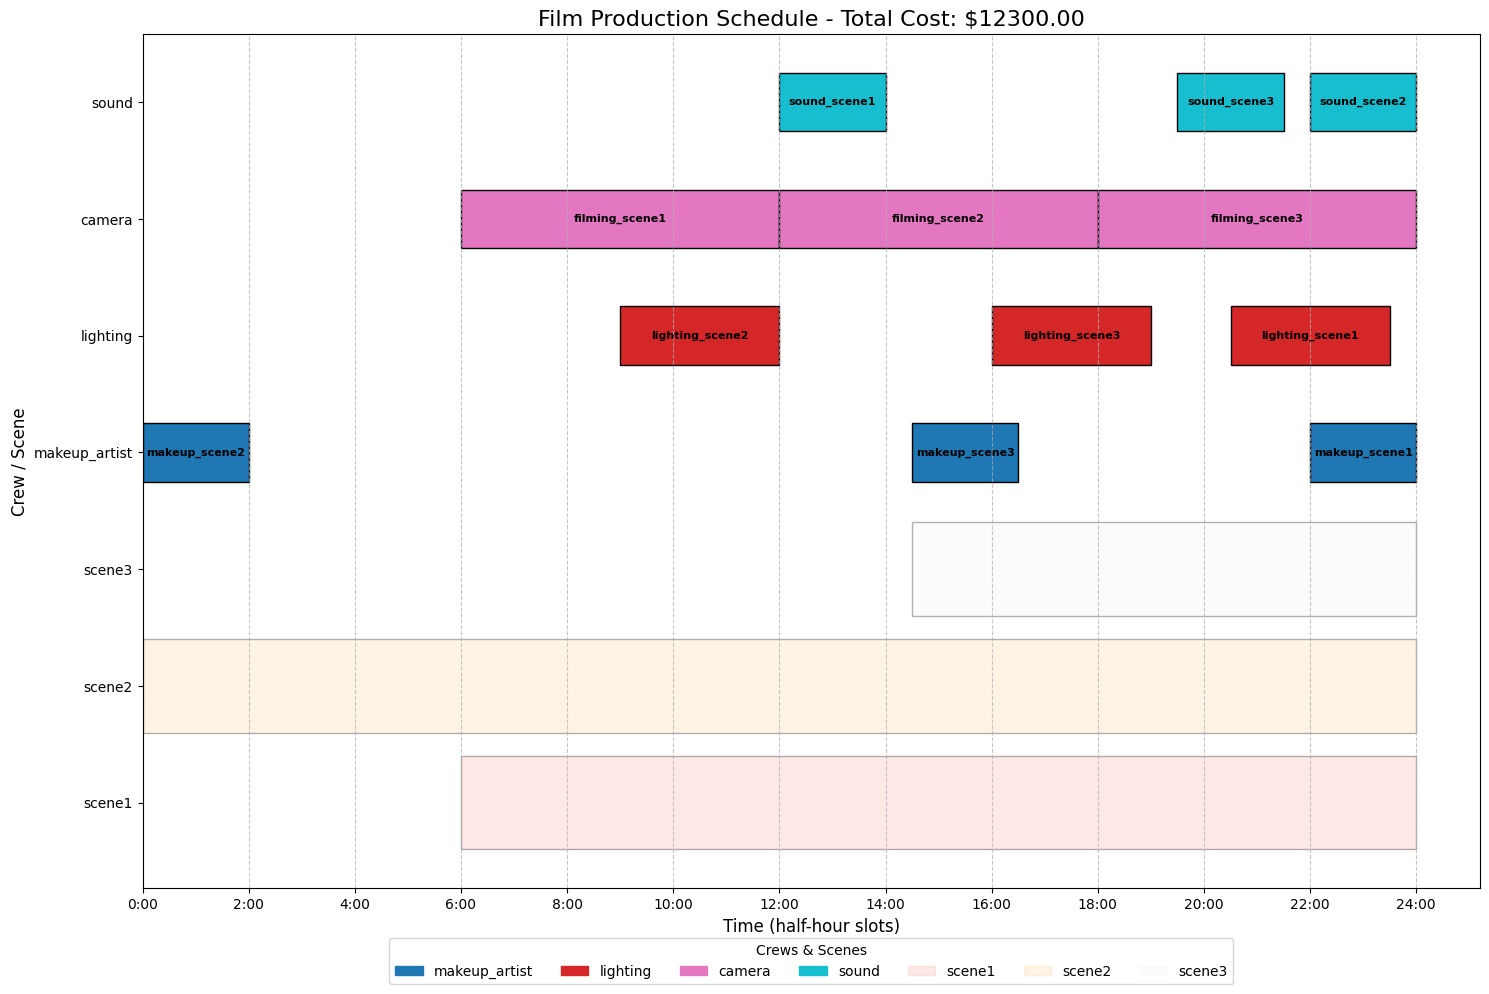

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from datetime import datetime, timedelta

# Create a Gantt chart visualization of the schedule
fig, ax = plt.subplots(figsize=(15, 10))

# Extract results from the model
task_assignments = []
for task in tasks:
    for crew in crews:
        for t in time_slots:
            if (task, crew, t) in x and x[task, crew, t].x > 0.5:
                # Get scene from task name (task format is action_sceneX)
                scene = task.split('_')[1]
                start_time = t
                end_time = t + task_duration[task]
                task_assignments.append({
                    'Task': task,
                    'Crew': crew,
                    'Start Time': start_time,
                    'End Time': end_time,
                    'Scene': scene
                })

# Convert to DataFrame for easier handling
task_df = pd.DataFrame(task_assignments)

# Get unique scenes
unique_scenes = sorted(list(set([task.split('_')[1] for task in tasks])))

# Create scene schedule dataframe (earliest start to latest end for each scene)
scene_data = []
for scene in unique_scenes:
    scene_tasks = task_df[task_df['Scene'] == scene]
    if not scene_tasks.empty:
        scene_start = scene_tasks['Start Time'].min()
        scene_end = scene_tasks['End Time'].max()
        scene_data.append({
            'Scene': scene,
            'Start Time': scene_start,
            'End Time': scene_end
        })
scene_df = pd.DataFrame(scene_data)

# Define colors for different crews and scenes
crew_colors = plt.cm.tab10(np.linspace(0, 1, len(crews)))
crew_color_map = {crew: crew_colors[i] for i, crew in enumerate(crews)}

scene_colors = plt.cm.Pastel1(np.linspace(0, 1, len(unique_scenes)))
scene_color_map = {scene: scene_colors[i] for i, scene in enumerate(unique_scenes)}

# Plot scene blocks first (as background)
for _, row in scene_df.iterrows():
    start_time = row['Start Time']
    end_time = row['End Time']
    scene = row['Scene']
    
    ax.barh(
        [scene], 
        [end_time - start_time], 
        left=[start_time],
        height=0.8, 
        color=scene_color_map[scene], 
        alpha=0.3, 
        edgecolor='black'
    )

# Plot tasks
for _, row in task_df.iterrows():
    task = row['Task']
    crew = row['Crew']
    start_time = row['Start Time']
    end_time = row['End Time']
    
    # Task duration
    duration = end_time - start_time
    
    # Create the task bar
    rect = ax.barh(
        [crew], 
        [duration], 
        left=[start_time],
        height=0.5, 
        color=crew_color_map[crew], 
        edgecolor='black'
    )
    
    # Add task label
    ax.text(
        start_time + duration/2, 
        crew, 
        task, 
        ha='center', 
        va='center', 
        color='black',
        fontweight='bold',
        fontsize=8
    )

# Format the chart
ax.set_yticks(crews + unique_scenes)
ax.set_yticklabels(crews + unique_scenes)

# Set x-axis as time slots
max_end_time = task_df['End Time'].max()
ax.set_xticks(range(0, max_end_time + 1, 4))  # Show every 2 hours (4 time slots)
ax.set_xticklabels([f"{t//2}:{'00' if t%2==0 else '30'}" for t in range(0, max_end_time + 1, 4)])
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Calculate total cost from the model
total_cost = model.objVal

# Add title and labels
ax.set_title(f'Film Production Schedule - Total Cost: ${total_cost:.2f}', fontsize=16)
ax.set_xlabel('Time (half-hour slots)', fontsize=12)
ax.set_ylabel('Crew / Scene', fontsize=12)

# Add legend for crews and scenes
crew_patches = [patches.Patch(color=crew_color_map[crew], label=crew) for crew in crews]
scene_patches = [patches.Patch(color=scene_color_map[scene], alpha=0.3, label=scene) for scene in unique_scenes]

# Combine legends
ax.legend(
    handles=crew_patches + scene_patches, 
    title="Crews & Scenes", 
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.05), 
    ncol=len(crews) + len(unique_scenes)
)

plt.tight_layout()
plt.savefig('production_schedule.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
model.getVars()

[<gurobi.Var x_makeup_scene1_makeup_artist_0 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_1 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_2 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_3 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_4 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_5 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_6 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_7 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_8 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_9 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_10 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_11 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_12 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_13 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_14 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_15 (value 0.0)>,
 <gurobi.Var x_makeup_scene1_makeup_artist_16 (val